In [2]:
# packges
import tensorflow as tf
import numpy as np
import pandas as pd

In [98]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import gc

In [142]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

In [179]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input

In [192]:
from keras.layers import LSTM
from keras.layers import Dropout

In [143]:
# read dataset
df_train = pd.read_csv('train.csv', index_col='ts_id')

D:\anaconda\envs\tf_gpu\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
# take a look at the dataset and plot it
df_train.head(3)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
ts_id                                                                      
0         0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1         0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2         0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   

       feature_0  feature_1  feature_2  ...  feature_120  feature_121  \
ts_id                                   ...                             
0              1  -1.872746  -2.191242  ...          NaN          NaN   
1             -1  -1.349537  -1.704709  ...          NaN          NaN   
2             -1   0.812780  -0.256156  ...          NaN          NaN   

       feature_122  feature_123  feature_124  feature_125  feature_126  \
ts_id                                                                    
0         1.168391     8.313583     1.782433    14.018213     2.653056   
1        -1.178850     1.777472    -0.915458     2.831612    -1.417010   
2         6.115747     9.667908     5.542871    11.671595     7.281757   

       feature_127  feature_128  feature_129  
ts_id                                         
0        12.600292     2.301488    11.445807  
1         2.297459    -1.304614     1.898684  
2        10.060014     6.638248     9.427299  

[3 rows x 137 columns]

In [254]:
# resp - resp4, total 5 collumns are what we need to predict
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390491 entries, 0 to 2390490
Data columns (total 137 columns):
 #    Column       Dtype  
---   ------       -----  
 0    date         int64  
 1    weight       float64
 2    resp_1       float64
 3    resp_2       float64
 4    resp_3       float64
 5    resp_4       float64
 6    resp         float64
 7    feature_0    int64  
 8    feature_1    float64
 9    feature_2    float64
 10   feature_3    float64
 11   feature_4    float64
 12   feature_5    float64
 13   feature_6    float64
 14   feature_7    float64
 15   feature_8    float64
 16   feature_9    float64
 17   feature_10   float64
 18   feature_11   float64
 19   feature_12   float64
 20   feature_13   float64
 21   feature_14   float64
 22   feature_15   float64
 23   feature_16   float64
 24   feature_17   float64
 25   feature_18   float64
 26   feature_19   float64
 27   feature_20   float64
 28   feature_21   float64
 29   feature_22   float64
 30   feature_23   flo

In [94]:
# clean NaN and check % missing value in the tatal dataset
missing = df_train.isnull().sum().sum()
total_numbers = np.product(df_train.shape)
print("NaN/Total ===> ",(missing/total_numbers) * 100, "%")

NaN/Total ===>  2.0649641024332577 %


In [95]:
del missing
del total_numbers
gc.collect()

241

In [112]:
# So, there're only 2.06% missing values. I decided to replace it with -999.(searched online, and find this way to deal with NaN)
spi = SimpleImputer(missing_values=np.nan, strategy='mean')
spi = spi.fit(df_train.values)
imputed_data = spi.transform(df_train.values)

In [114]:
imputed_data = pd.DataFrame(imputed_data, columns=df_train.columns)
imputed_data.head(6)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0   0.0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1   0.0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2   0.0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3   0.0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4   0.0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   
5   0.0   0.000000 -0.001047 -0.002700  0.000743  0.004667  0.001282   

   feature_0  feature_1  feature_2  ...  feature_120  feature_121  \
0        1.0  -1.872746  -2.191242  ...     0.335127     0.268776   
1       -1.0  -1.349537  -1.704709  ...     0.335127     0.268776   
2       -1.0   0.812780  -0.256156  ...     0.335127     0.268776   
3       -1.0   1.174378   0.344640  ...     0.335127     0.268776   
4        1.0  -3.172026  -3.093182  ...     0.335127     0.268776   
5       -1.0  -1.499681  -1.928023  ...     0.335127     0.268776   

   feature_122  feature_123  feature_124  feature_125  feature_126  \
0     1.168391     8.313583     1.782433    14.018213     2.653056   
1    -1.178850     1.777472    -0.915458     2.831612    -1.417010   
2     6.115747     9.667908     5.542871    11.671595     7.281757   
3     2.838853     0.499251     3.033732     1.513488     4.397532   
4     0.344850     4.101145     0.614252     6.623456     0.800129   
5     0.337112     4.079450     0.613967     6.622410     0.799525   

   feature_127  feature_128  feature_129  
0    12.600292     2.301488    11.445807  
1     2.297459    -1.304614     1.898684  
2    10.060014     6.638248     9.427299  
3     1.266037     3.856384     1.013469  
4     5.233243     0.362636     3.926633  
5     5.231833     0.360831     3.922324  

[6 rows x 137 columns]

In [115]:
missing = imputed_data.isnull().sum().sum()
total_numbers = np.product(imputed_data.shape)
df_cleaned = imputed_data.copy()
print("After imputing % ===> ",(missing/total_numbers) * 100, "%")

After imputing % ===>  0.0 %


In [118]:
del missing
del total_numbers
del imputed_data
del spi
gc.collect()

NameError: name 'missing' is not defined

In [ ]:
# According to https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation 
# And example_sample_submission.csv only contains ts_id and action, action means if we make the deal or not
# So, for our project, we calculate the action before training and taking it as the target. 
# Finally, we'll use 'action' to get the acc. (spliting the data into 30% as test set)
# here's our code
# NOTE: we got this approach by ploting the dataset and compare the resp and time. 
# We changed the order of the notebook, and put the visualization part after calculating 'action'

In [120]:
df_cleaned['action'] = ((df_cleaned['weight'].values * df_cleaned['resp'].values) > 0).astype('int')

In [123]:
df_cleaned.action.head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    1
19    0
Name: action, dtype: int32

In [ ]:
# here, we got the target and the next step is to SPLIT and VISUALIZE it

In [124]:
# data split ---> train_X, train_y, test_X, test_y
# Y = df_train[['weight','resp','resp_1','resp_2','resp_3','resp_4']]
Y = df_cleaned[['action']]
X = df_cleaned.drop(['weight','resp','resp_1','resp_2','resp_3','resp_4', 'action'], axis=1)

In [126]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.33, random_state=6)

In [129]:
del df_cleaned
gc.collect()

51

In [130]:
train_X

date  feature_0  feature_1  feature_2  feature_3  feature_4  \
313567    45.0       -1.0   1.677386   1.617180   3.449476   3.416690   
806550   161.0       -1.0  -1.268499  -1.387763  -0.887104  -0.814675   
580214   100.0       -1.0   1.354775   3.004580   1.232573   1.876016   
926358   191.0       -1.0  -1.382388  -0.866798   0.667313   0.983613   
839334   169.0        1.0   0.588988   2.035578   0.435263   0.701047   
...        ...        ...        ...        ...        ...        ...   
1398041  298.0        1.0  -0.349311  -0.296749   0.753171   0.727075   
1008464  210.0        1.0   2.888792   3.033758  -3.018337  -3.022047   
1812436  386.0        1.0   1.346779   3.252467  -0.521487  -0.754417   
903881   185.0       -1.0  -3.172026  -3.093182  -6.547866  -5.116462   
1211274  257.0        1.0   1.125453  -0.269337  -2.350846  -1.334133   

         feature_5  feature_6  feature_7  feature_8  ...  feature_120  \
313567    1.768750   1.684025   2.240244   2.645232  ...     0.203256   
806550   -0.822541  -0.797271  -1.869077  -2.306591  ...     0.482639   
580214    1.486620   2.319022   1.321279   2.614469  ...    -0.601919   
926358    0.439042   0.679529   1.457177   2.798464  ...    -1.795140   
839334    1.850593   2.997210   0.051777   0.026828  ...    -1.697798   
...            ...        ...        ...        ...  ...          ...   
1398041   0.697643   0.711736   0.248892   0.287211  ...    -0.403979   
1008464  -1.472264  -1.412617   0.647889   0.686993  ...     0.577517   
1812436  -0.604969  -0.967170  -1.247822  -2.126620  ...    -0.900457   
903881   -4.251655  -3.194665   2.286220   1.976990  ...    -0.130442   
1211274  -1.619137  -0.886000   2.797065   1.941249  ...    -0.218370   

         feature_121  feature_122  feature_123  feature_124  feature_125  \
313567      0.984547     0.074629     0.275235     0.233750     1.121224   
806550      1.439313    -1.166037    -2.311752     0.078836     0.314382   
580214     -0.551112    -0.842566    -1.028667    -0.723017    -1.561810   
926358     -0.210304    -1.453998     1.121397    -1.281817     1.133264   
839334      2.580780    -2.159906     1.196532    -1.489777     2.730167   
...              ...          ...          ...          ...          ...   
1398041    -2.363527    -0.900893    -2.440309    -0.559465    -3.108370   
1008464    -1.124597     0.835492    -0.618966     0.547682    -1.241407   
1812436     2.731878    -2.199444    -1.107469    -0.987906     1.934237   
903881     -3.763679     0.557567    -1.914917     0.080493    -3.660110   
1211274    -2.127336     0.497827    -0.212077     0.131021    -1.205078   

         feature_126  feature_127  feature_128  feature_129  
313567      0.290995     0.666147     0.294845     0.582347  
806550     -0.471239    -0.945317    -0.869617    -1.538004  
580214     -1.068846    -1.038128    -0.999829    -1.034709  
926358     -1.931149     1.241497    -1.537226     1.439966  
839334     -2.719254     1.791080    -2.538954     1.223114  
...              ...          ...          ...          ...  
1398041    -1.220428    -2.641509    -1.083993    -2.349715  
1008464     0.858228    -0.892891     0.866733    -0.697959  
1812436    -1.732488     1.117435    -1.909705     0.193813  
903881     -0.017917    -2.747143     0.226836    -2.215233  
1211274     0.517432    -0.400705     0.535104    -0.280365  

[1601628 rows x 131 columns]

In [131]:
train_y

action
313567        1
806550        0
580214        0
926358        0
839334        1
...         ...
1398041       0
1008464       1
1812436       0
903881        1
1211274       1

[1601628 rows x 1 columns]

In [139]:
# sort them, better visualizing
train_X = train_X.sort_index()

In [141]:
train_y = train_y.sort_index()

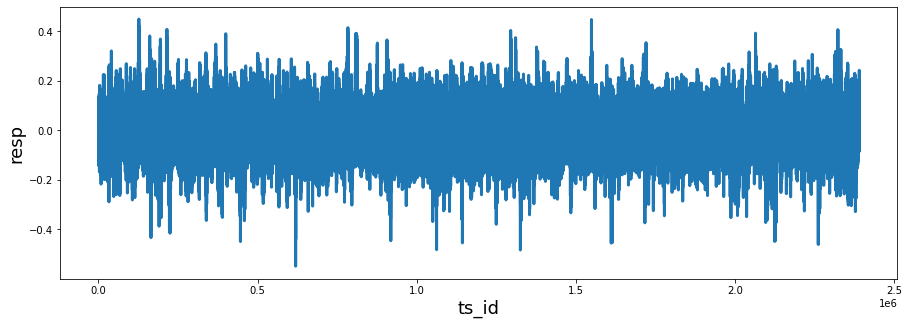

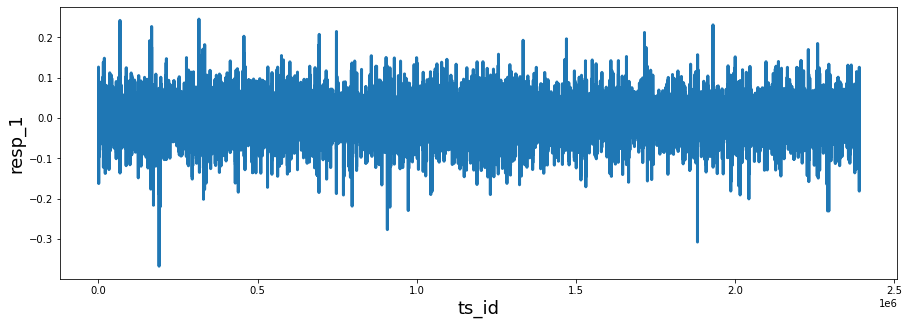

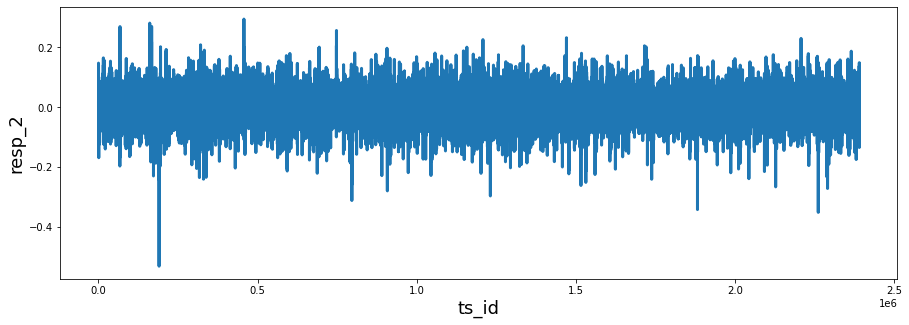

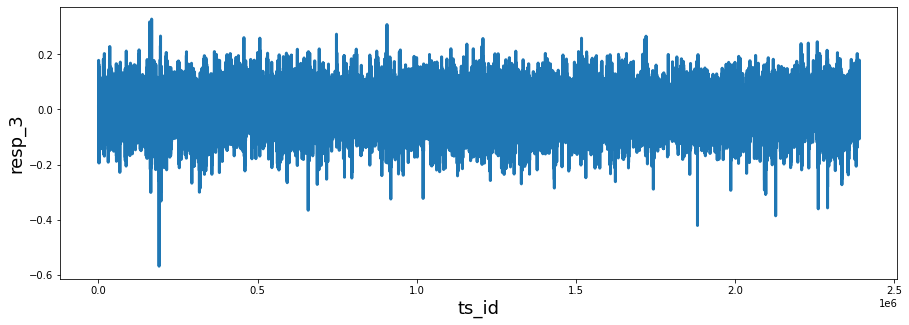

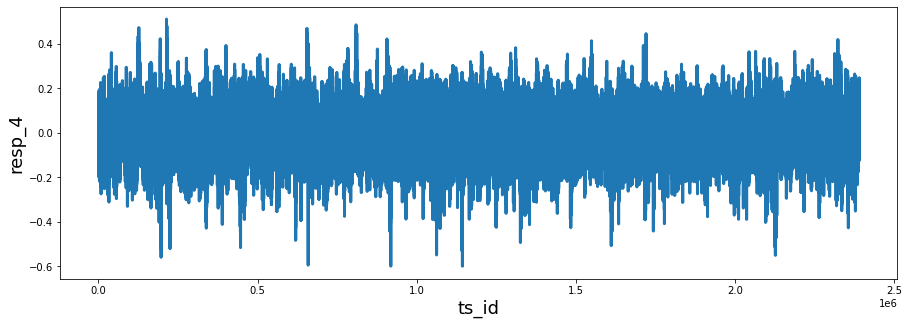

In [144]:
# ts_id is the order of each row, sorted by date
# compare the trend of different resp on different date
# output 5 plots
resps = ['resp','resp_1','resp_2','resp_3','resp_4']
for r in resps:
    fig, ax = plt.subplots(figsize=(15, 5))
    balance= pd.Series(df_train[r])
    ax.set_xlabel ("Trade", fontsize=18)
    ax.set_ylabel (r, fontsize=18);
    balance.plot(lw=3);

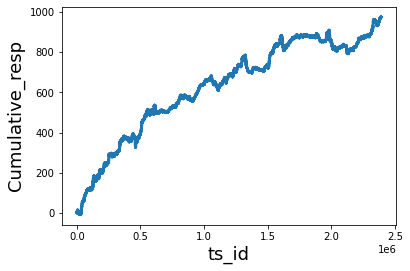

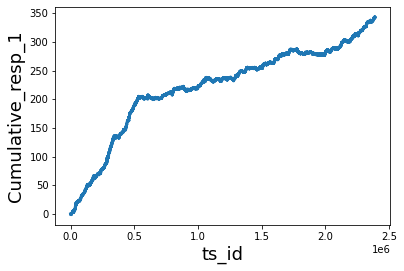

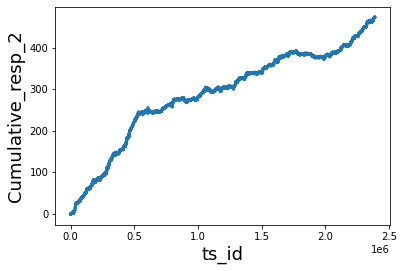

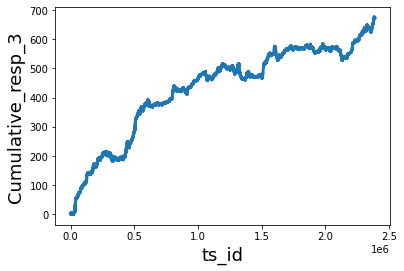

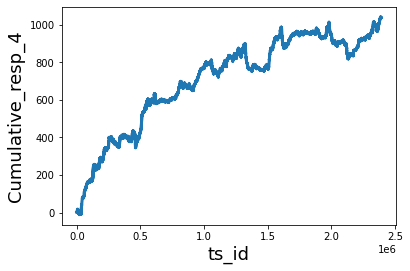

In [145]:
# Cumulative resp
for r in resps:
    fig, ax = plt.subplots()
    resp= pd.Series(df_train[r]).cumsum()
    ax.set_xlabel ("Trade", fontsize=18)
    ax.set_ylabel ("Cumulative_" + r, fontsize=18);
    resp.plot(lw=3);

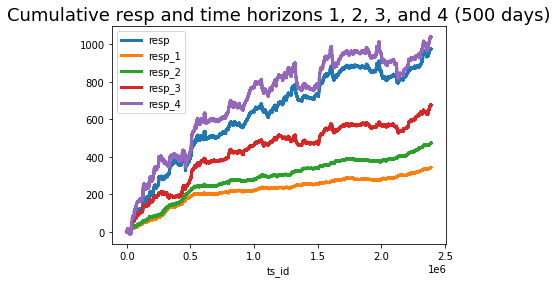

In [146]:
# Cumulative resps in one plot 
fig, ax = plt.subplots()
resp= pd.Series(df_train['resp']).cumsum()
resp_1= pd.Series(df_train['resp_1']).cumsum()
resp_2= pd.Series(df_train['resp_2']).cumsum()
resp_3= pd.Series(df_train['resp_3']).cumsum()
resp_4= pd.Series(df_train['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=10)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend()

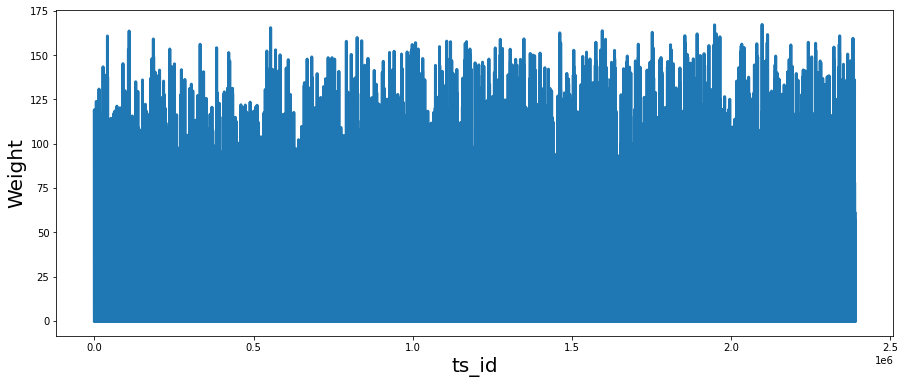

In [147]:
# weight over time(ts_id)
fig, ax = plt.subplots(figsize=(15,6))
resp= pd.Series(df_train['weight'])
ax.set_xlabel ("TS-ID", fontsize=20)
ax.set_ylabel ("Weight", fontsize=20);
resp.plot(lw=3);

In [148]:
# clean ram
gc.collect()


26285

In [152]:
df_features = pd.read_csv('features.csv')

In [154]:
df_features.feature

0        feature_0
1        feature_1
2        feature_2
3        feature_3
4        feature_4
          ...     
125    feature_125
126    feature_126
127    feature_127
128    feature_128
129    feature_129
Name: feature, Length: 130, dtype: object

D:\anaconda\envs\tf_gpu\lib\site-packages\seaborn\axisgrid.py:1183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(len(y_vars), len(x_vars),


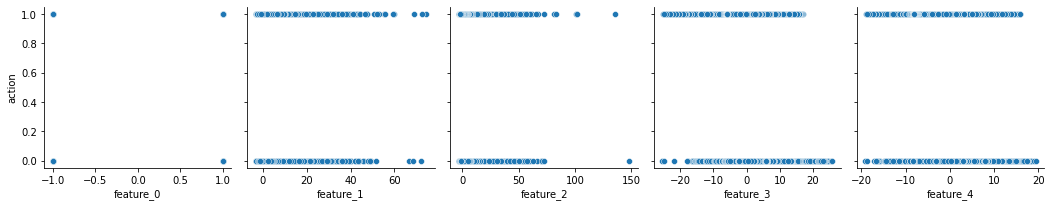

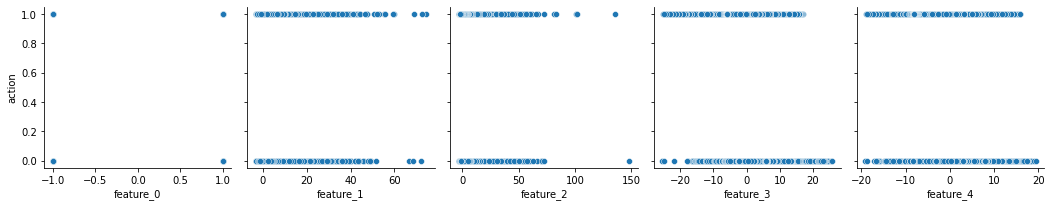

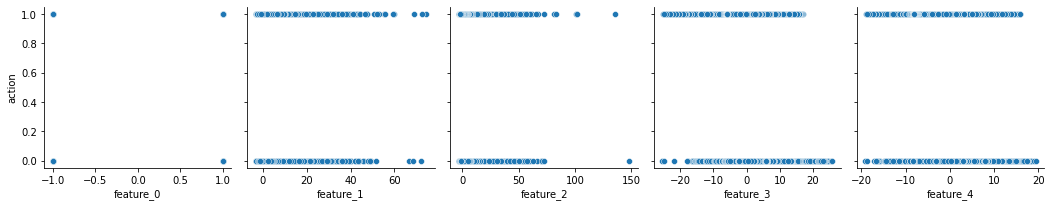

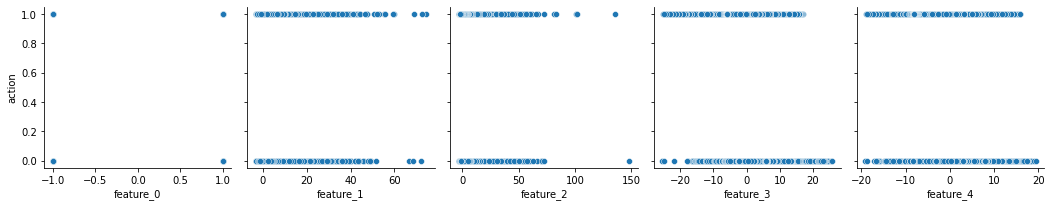

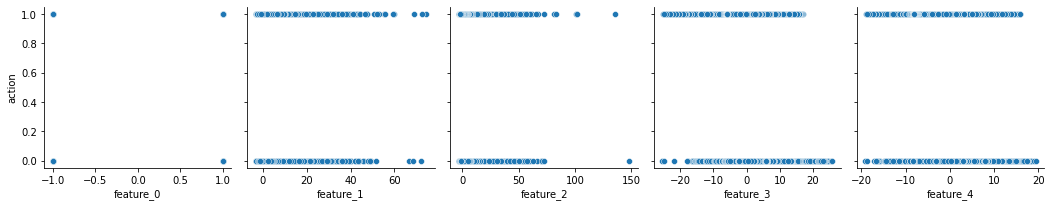

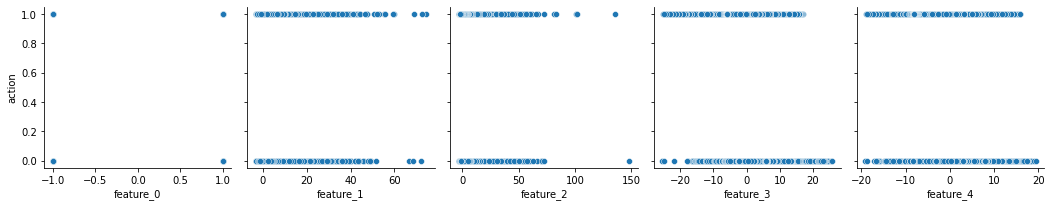

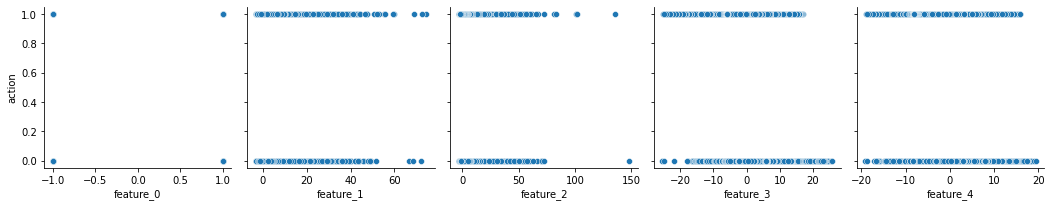

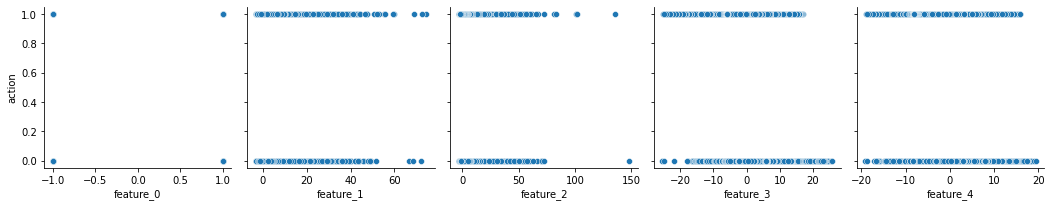

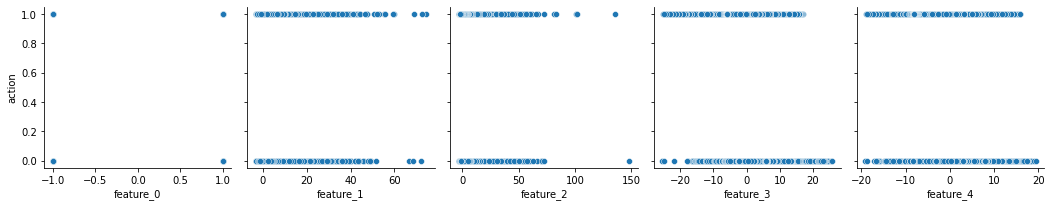

Error in callback <function flush_figures at 0x0000018206060D30> (for post_execute):


KeyboardInterrupt: 

In [166]:
# pairplot action over time(ts_id)
temp_data = pd.concat([train_X, train_y], axis=1)

# too many plots, I can only pair 5 at each time
# sns.pairplot(data=temp_data,
#                   y_vars=['action'],
#                   x_vars=df_features.feature)
i = 0
while(i < 129):
    pp = sns.pairplot(data=temp_data,
                      y_vars=['action'],
                      x_vars=df_features.feature[0:5])
    pp.fig.set_size_inches(15,3)
    i = i+5

In [ ]:
# PART1 -----------> LR MODEL

In [168]:
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression()

In [171]:
lr_train_pred = lr.predict(train_X)
lr_test_pred = lr.predict(test_X)
# scores
print("LR train MSE:", mean_squared_error(train_y, lr_train_pred))
print("LR test MSE:", mean_squared_error(test_y, lr_test_pred))
print("LR train RMSE:", np.sqrt(mean_squared_error(train_y, lr_train_pred)))
print("LR test RMSE:", np.sqrt(mean_squared_error(test_y, lr_test_pred)))

LR train MSE: 0.23748720202421916
LR test MSE: 0.2374970523630953
LR train RMSE: 0.48732658661745426
LR test RMSE: 0.4873366930194106


In [ ]:
# PART2 -----------> NN MODEL

In [181]:
train_X.shape

(1601628, 131)

In [222]:
# how to choose activation
NNmodel = Sequential()
NNmodel.add(Dense(29, input_shape=train_X.shape, activation='tanh'))
NNmodel.add(Dense(24, activation='tanh'))
NNmodel.add(Dense(19, activation='tanh'))
NNmodel.add(Dense(1))
NNmodel.compile(optimizer = 'SGD', loss='mse')
print(NNmodel.summary())

ResourceExhaustedError: OOM when allocating tensor with shape[131,1601628] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [186]:
NNhistory = NNmodel.fit(train_X, train_y, epochs = 3)

Epoch 1/10
50051/50051 [==============================] - 108s 2ms/step - loss: 0.2399
Epoch 2/10
50051/50051 [==============================] - 103s 2ms/step - loss: 0.2397
Epoch 3/10
50051/50051 [==============================] - 106s 2ms/step - loss: 0.2394
Epoch 4/10
50051/50051 [==============================] - 108s 2ms/step - loss: 0.2393
Epoch 5/10
50051/50051 [==============================] - 109s 2ms/step - loss: 0.2389
Epoch 6/10
50051/50051 [==============================] - 108s 2ms/step - loss: 0.2388
Epoch 7/10
50051/50051 [==============================] - 106s 2ms/step - loss: 0.2388
Epoch 8/10
50051/50051 [==============================] - 105s 2ms/step - loss: 0.2385
Epoch 9/10
50051/50051 [==============================] - 106s 2ms/step - loss: 0.2384
Epoch 10/10
50051/50051 [==============================] - 106s 2ms/step - loss: 0.2382


In [188]:
print(NNhistory.evaluate(train_X,train_y))
print(NNhistory.evaluate(test_X,test_y))

50051/50051 [==============================] - 63s 1ms/step - loss: 0.2386
0.23864491283893585
24652/24652 [==============================] - 29s 1ms/step - loss: 0.2388
0.23877979815006256


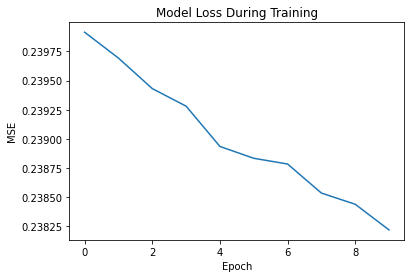

In [189]:
plt.figure()
plt.plot(NNhistory.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [238]:
# test = model.predict(test_y)

In [ ]:
# PART3 -----------> RNN(LSTM) MODEL

In [239]:
train_X.shape

(1601628, 131)

In [240]:
def create_mlp(
    num_columns, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate
):

    inp = tf.keras.layers.Input(shape=(num_columns,))
    x = tf.keras.layers.BatchNormalization()(inp)
    x = tf.keras.layers.Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 1])(x)

    x = tf.keras.layers.Dense(num_labels)(x)
    out = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing),
        metrics=tf.keras.metrics.AUC(name="AUC"),
    )

    return model


In [241]:
batch_size = 5000
hidden_units = [150, 150, 150]
dropout_rates = [0.2, 0.2, 0.2, 0.2]
label_smoothing = 1e-2
learning_rate = 1e-3

In [252]:
train_X = train_X.drop(['date'], axis=1)

In [253]:
clf = create_mlp(
    len(df_features), 5, hidden_units, dropout_rates, label_smoothing, learning_rate
    )

clf.fit(train_X, train_y, epochs=200, batch_size=5000)


models = []

models.append(clf)

th = 0.5000

Epoch 1/200


ValueError: in user code:

    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:755 train_step
        loss = self.compiled_loss(
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\backend.py:4979 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:173 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 5) vs (None, 1))


In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()